In [1]:
# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import sys, importlib

# import utility

env = 'dev'

# DWM project - Explorative Data Analysis

The aim of this notebook is to 
- understand the data structure 
- understand all possible issues on the data that can compromise the model creation phase
- try to solve the aforementioned issues

In order to make this analysis as clear and self-explanatory as possible, I'll try to use many graphical representations.
Many ideas on graphs are taken from the professor classes, kaggle competitions and from the internet, especially from Towards Data Science and implemented with the help of my best friend, Stack Overflow.

### Data import
I concatenate all properties data into a dataframe and all transaction data into another.
The analysis is done on all properties (one analysis) and all transactions (another analysis), because
1. it's more data in which make statistics (and we know that more data implies better statistics)
2. I see no reason to take them independently, they are just homes, and because of the short temporal span I assume that they don't change their features.

Due to the lack of powerful hardware to make the computation, I decided to take only a part of the whole dataset, that is 100k house properties out of almost 3M for both `properties_2016` and `properties_2017`. This was decided after having found that the time for even easy computation was too long.
This of course came at the cost of considerations and models that can be not as good as the ones created with the whole dataset; however the process is the same.

In [3]:
# Read data
n = 200000
properties_2016 = pd.read_csv("../DWMProjectData/properties_2016.csv", nrows=n)
properties_2017 = pd.read_csv("../DWMProjectData/properties_2017.csv", nrows=n)
transactions_2016 = pd.read_csv("../DWMProjectData/train_2016_v2.csv")
transactions_2017 = pd.read_csv("../DWMProjectData/train_2017.csv")

C:\Users\marco\anaconda3\envs\DWMProject\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\marco\anaconda3\envs\DWMProject\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (22,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


A warning is raised due to some columns of type object and with NaN value: I'll handle this later.

In [4]:
# Merge the properties datasets
properties = pd.concat([properties_2016, properties_2017], axis=0,
                       ignore_index=True)  # need to set ignore_index=True to change indexes to avoid hereafter problems
transactions = pd.concat([properties_2016, properties_2017], axis=0, ignore_index=True)

In [5]:
# Delete datasets that I'll not use to save memory
del properties_2016, properties_2017, transactions_2016, transactions_2017

## Explorative analysis of `properties` dataset with data cleaning

### Dataset exploration
I can already imagine a problem: some houses are repeated on the dataset of 2016 and 2017. In order to save memory, it's a good idea to keep only one house if they are exacly the same.

In [6]:
# Drop duplicates on concatenated property dataset
print(f"#Properties rows before duplicate removal: {properties.shape[0]}")
properties.drop_duplicates(keep='first', inplace=True)
print(f"#Properties rows after duplicate removal: {properties.shape[0]}")
print(
    f"Properties has {properties.duplicated(subset=['parcelid'], keep=False).sum()} houses repeated with differents attributes [{round(properties.duplicated(subset=['parcelid'], keep=False).sum() * 100 / properties.shape[0], 2)}% of data]")

#Properties rows before duplicate removal: 400000
#Properties rows after duplicate removal: 399788
Properties has 397920 houses repeated with differents attributes [99.53% of data]


It seems that many houses are repeated, but with different values in some columns. Let's have a look on some record in order to have a more clear idea on what's happening:

In [7]:
properties[properties.duplicated(subset=['parcelid'], keep=False)].sort_values(by='parcelid').iloc[0:10]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
58104,10711745,1.0,NaN,NaN,3.0,4.0,NaN,4.0,3.0,NaN,...,NaN,NaN,237085.0,457619.0,2015,220534.0,5863.18,NaN,NaN,6.037113e+13
258273,10711745,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,240700.0,464597.0,2016,223897.0,5863.18,NaN,NaN,6.037113e+13
377584,10711761,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,165109.0,279961.0,2016,114852.0,3562.68,NaN,NaN,6.037113e+13
177050,10711761,1.0,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,162629.0,275756.0,2015,113127.0,3562.68,NaN,NaN,6.037113e+13
243294,10711767,NaN,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,181354.0,373108.0,2016,191754.0,4642.73,NaN,NaN,6.037113e+13
43167,10711767,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,178630.0,367504.0,2015,188874.0,4642.73,NaN,NaN,6.037113e+13
162188,10711783,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,106500.0,525000.0,2015,418500.0,6640.79,NaN,NaN,6.037113e+13
362669,10711783,NaN,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,109289.0,540460.0,2016,431171.0,6640.79,NaN,NaN,6.037113e+13
228470,10711789,NaN,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,147018.0,296477.0,2016,149459.0,3798.51,NaN,NaN,6.037113e+13
28385,10711789,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,144810.0,292024.0,2015,147214.0,3798.51,NaN,NaN,6.037113e+13


We can notice that many houses are duplicated; some houses are exactly the same over 2016 and 2017 and other has changed. Taking a brief look at the data, the changes mainly involve columns like `structuretaxdollarcnt`, `taxvaluedollarcnt` and `landtaxvaluedollarcnt`, that is normal that change over the years.
I came at the conclusion that this duplicated but slightly different rows can be both removed and keep, for different reasons:
- it's a good idea to remove them because you basically have half the data to manage, but at the same time
- it's a good idea to keep them in order to have a better prediction over different years

I go for the second option, since the aim of the project is give predictions for different time periods.

### Analysis on rows: find out the rows that has more than `threshold` missing values
(mean is 49% of missing values per row)

I keep only that rows, since if a row has too missing values is not a good sample to build the model

In [8]:
print(f"#rows before: {properties.shape[0]}")
threshold = 0.6  # seems a good compromise
properties = properties[properties.isnull().sum(axis=1) / properties.shape[1] < threshold]
print(f"#rows after:  {properties.shape[0]}")

#rows before: 399788
#rows after:  389108


### Analysis on column names
I notice from columns names that some columns has similar names and I suspect that can contain the same information or are different classification system for the same things. I try to figure it out:

In [10]:
group_pool = ['pooltypeid10','pooltypeid2','pooltypeid7']
group_sqft = ['finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6']
group_bath = ['fullbathcnt', 'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr']

to_test = 10000 # I don't test on all the dataset since it takes lot of time
n_ok = 0 # for n_ok I mean the number of rows that satisfy the condition: row with one unique value (i.e. all are null or there is only one unique value (not counting nan))
n_no = 0 # for n_no I mean all the rows that dosen't satisfy the ok condition
for r in properties.index[0:to_test]:
    if properties.iloc[r, :][group_pool].isna().sum() == len(group_pool) or properties.iloc[r, :][group_pool].nunique() == 1:
        n_ok+=1
    else:
        n_no+=1
print(f"POOL: #ok: {n_ok} | #n_no: {n_no}")

n_ok = 0 # for n_ok I mean the number of rows that satisfy the condition: row with one unique value (i.e. all are null or there is only one unique value (not counting nan))
n_no = 0 # for n_no I mean all the rows that dosen't satisfy the ok condition
for r in properties.index[0:to_test]:
    if properties.iloc[r, :][group_sqft].isna().sum() == len(group_sqft) or properties.iloc[r, :][group_sqft].nunique() == 1:
        n_ok+=1
    else:
        n_no+=1
print(f"SQFT: #ok: {n_ok} | #n_no: {n_no}")

n_ok = 0 # for n_ok I mean the number of rows that satisfy the condition: row with one unique value (i.e. all are null or there is only one unique value (not counting nan))
n_no = 0 # for n_no I mean all the rows that dosen't satisfy the ok condition
for r in properties.index[0:to_test]:
    if properties.iloc[r, :][group_bath].isna().sum() == len(group_bath) or properties.iloc[r, :][group_bath].nunique() == 1:
        n_ok+=1
    else:
        n_no+=1
print(f"BATH: #ok: {n_ok} | #n_no: {n_no}")

POOL: #ok: 10000 | #n_no: 0
SQFT: #ok: 9629 | #n_no: 371
BATH: #ok: 9725 | #n_no: 275
POOL: #ok: 10000 | #n_no: 0
SQFT: #ok: 9629 | #n_no: 371
BATH: #ok: 9725 | #n_no: 275


It seems that not alway but very often the columns share the same content, so I think it's a good idea to merge the column inside each group together.
Let's do it:

In [ ]:
# Merge pools: I only keep pooltypeid2
i=0
for r in properties.index[0:10]:
    print(properties.loc[group_pool].iloc[r].unique())
    #properties["pooltypeid2"] = properties.iloc[r]

parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64
parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64
parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64
parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64
parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64
parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64
parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64
parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64
parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64
parcelid                 10879947.0
airconditioningtypeid           NaN
Name: 4, dtype: float64


KeyError: "None of [Index(['pooltypeid10', 'pooltypeid2', 'pooltypeid7'], dtype='object')] are in the [index]"

### Data type exploration

####  Missing values (aka NaN) managment
Let's visualize the percentual of missing values for each column. To avoid to print all column, I set a threshold.
I think it can be a good idea to remove some column that have really few data and for which I have no good idea on how to fill the NaN with intelligent values.

In [479]:
from texttable import Texttable

threshold = 0.90
t = Texttable()
t.add_rows([['Column', '% missing values']])
for col in properties.columns:
    current_threshold = properties[col].isna().sum() / properties.shape[0]
    if current_threshold > threshold:
        t.add_row([col, f'{round(current_threshold * 100, 2)}%'])
print(t.draw())

+--------------------------+------------------+
|          Column          | % missing values |
+==========================+==================+
| architecturalstyletypeid | 99.81%           |
+--------------------------+------------------+
| basementsqft             | 99.95%           |
+--------------------------+------------------+
| buildingclasstypeid      | 99.55%           |
+--------------------------+------------------+
| decktypeid               | 99.39%           |
+--------------------------+------------------+
| finishedfloor1squarefeet | 92.74%           |
+--------------------------+------------------+
| finishedsquarefeet13     | 99.99%           |
+--------------------------+------------------+
| finishedsquarefeet15     | 93.47%           |
+--------------------------+------------------+
| finishedsquarefeet50     | 92.74%           |
+--------------------------+------------------+
| finishedsquarefeet6      | 99.29%           |
+--------------------------+------------

I remove `architecturalstyletypeid`, `basementsqft`, `buildingclasstypeid`, `decktypeid`, `storytypeid`,`yardbuildingsqft17`, `yardbuildingsqft26`, `taxdelinquencyflag`, `taxdelinquencyyear`.
I keep the other because they can be useful.

We can summarize the problem of filling the NaN as
- does the absence of the value mean that the value is 0 or
- does the absence of the value mean that that value was not registered while evalutating the house?

Methods:
- for some columns is trivial; for example, for `pools`, NaN will become 0, because we are quite sure that that house dosen't have a pool, since a pool is an important feature and must be taken into account while evaluating an house. I'll call this categories `fill_zero` in the code and I'll fillwith zero this columns
- for others such as `finishedfloor`, it'll be harder. Indeed here we cannot set finishedfloor as 0, because a house with 0sqft of finished floor have no sense, so I need to estimate the value, for example by setting it as the mean of the observations. A better estimation can be done by creating a model that finds the most similar houses and approximate the price as the mean of that, but let's keep it simple for now, since I'll have the opportunity to create some model in the second part of this project.
 Here I distinguish two types of columns:
    - categorical columns, that will be filled with mode of that column
    - numerical columns, that will be filled with mean of that column
- in some cases such as latitude and longitude, I don't have any good idea on how to manage them, so I'll drop them

In [480]:
#print(properties.columns[ properties.isna().any()].tolist())

fill_zero = ['threequarterbathnbr', 'fireplacecnt', 'fireplaceflag', 'garagecarcnt', 'garagetotalsqft',
             'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7']
fill_categorical = ['airconditioningtypeid', 'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid',
                    'propertycountylandusecode', 'propertylandusetypeid',
                    'propertyzoningdesc', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty',
                    'regionidcity', 'regionidzip', 'regionidneighborhood', 'typeconstructiontypeid',
                    'unitcnt']
fill_numerical = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'finishedfloor1squarefeet',
                  'calculatedfinishedsquarefeet', 'finishedsquarefeet6', 'finishedsquarefeet12', 'finishedsquarefeet13',
                  'finishedsquarefeet15', 'finishedsquarefeet50', 'fullbathcnt', 'lotsizesquarefeet', 'numberofstories',
                  'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt',
                  'landtaxvaluedollarcnt', 'taxamount', 'assessmentyear']
to_drop = ['latitude', 'longitude', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid',
           'storytypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'taxdelinquencyflag', 'taxdelinquencyyear']

print(f"#columns before: {properties.shape[1]}")

for c in fill_zero:
    properties[c].fillna(value=0, inplace=True)
for c in fill_numerical:
    properties[c].fillna(value=round(properties[c].mean()), inplace=True)
for c in fill_categorical:
    properties[c].fillna(value=properties[c].mode()[0], inplace=True)
properties.drop(columns=to_drop, inplace=True)

# print(len(fill_categorical) + len(fill_numerical) + len(to_drop) + len(fill_zero) + 1)
print(f"#columns after: {properties.shape[1]}")

#columns before: 58
#columns after: 47


#### Types exploration
I print all the types of the columns to make sure there is no unusual or strange type to deal with

In [481]:
for col in properties.columns:
    print(f"{properties.columns.get_loc(col)} | {col}: {properties[col].dtype}")

0 | parcelid: int64
1 | airconditioningtypeid: float64
2 | bathroomcnt: float64
3 | bedroomcnt: float64
4 | buildingqualitytypeid: float64
5 | calculatedbathnbr: float64
6 | finishedfloor1squarefeet: float64
7 | calculatedfinishedsquarefeet: float64
8 | finishedsquarefeet12: float64
9 | finishedsquarefeet13: float64
10 | finishedsquarefeet15: float64
11 | finishedsquarefeet50: float64
12 | finishedsquarefeet6: float64
13 | fips: int64
14 | fireplacecnt: float64
15 | fullbathcnt: float64
16 | garagecarcnt: float64
17 | garagetotalsqft: float64
18 | hashottuborspa: object
19 | heatingorsystemtypeid: float64
20 | lotsizesquarefeet: float64
21 | poolcnt: float64
22 | poolsizesum: float64
23 | pooltypeid10: float64
24 | pooltypeid2: float64
25 | pooltypeid7: float64
26 | propertycountylandusecode: object
27 | propertylandusetypeid: int64
28 | propertyzoningdesc: object
29 | rawcensustractandblock: float64
30 | regionidcity: float64
31 | regionidcounty: int64
32 | regionidneighborhood: float

Types are int64, float64 and object. They are ok but some type cast work can be done.

#### Type cast
I think it's a good idea to switch from int64 and float64 to int32 since the ensure enough precision for the task we are required to perform.
The only measurement that might require a float precision are the areas, but since they are measured in sqft, a change of a single unit in sqft is detailed enough for the aim of the project

In [482]:
from sys import getsizeof

print(f"size of properties before: {round(getsizeof(properties) / 1000000, 2)} MB")

# cast types
for col in properties.columns:
    if properties[col].dtype == 'int64' or properties[col].dtype == 'float64':
        print(f"convert {col} to int32")
        properties[col] = properties[col].astype('int32')
    else:
        print(f"skip {col}")

print(f"size of properties after: {round(getsizeof(properties) / 1000000, 2)} MB")

size of properties before: 209.67 MB
convert parcelid to int32
convert airconditioningtypeid to int32
convert bathroomcnt to int32
convert bedroomcnt to int32
convert buildingqualitytypeid to int32
convert calculatedbathnbr to int32
convert finishedfloor1squarefeet to int32
convert calculatedfinishedsquarefeet to int32
convert finishedsquarefeet12 to int32
convert finishedsquarefeet13 to int32
convert finishedsquarefeet15 to int32
convert finishedsquarefeet50 to int32
convert finishedsquarefeet6 to int32
convert fips to int32
convert fireplacecnt to int32
convert fullbathcnt to int32
convert garagecarcnt to int32
convert garagetotalsqft to int32
skip hashottuborspa
convert heatingorsystemtypeid to int32
convert lotsizesquarefeet to int32
convert poolcnt to int32
convert poolsizesum to int32
convert pooltypeid10 to int32
convert pooltypeid2 to int32
convert pooltypeid7 to int32
skip propertycountylandusecode
convert propertylandusetypeid to int32
skip propertyzoningdesc
convert rawcensu

The saved space is significant, so maybe I can use this space to upload more data in order to have better models.

#### Objects handle
Let's see what are the objects and what's inside

In [483]:
for o in properties.columns:
    if properties[o].dtype == 'object':
        if properties[o].nunique(dropna=False) < 10:
            print(f"{o.upper()} (#unique={properties[o].nunique(dropna=False)}) {properties[o].unique()}")
        else:
            print(f"{o.upper()} (#unique={properties[o].nunique(dropna=False)})[...]")

HASHOTTUBORSPA (#unique=2) [0 True]
PROPERTYCOUNTYLANDUSECODE (#unique=113)[...]
PROPERTYZONINGDESC (#unique=2705)[...]
FIREPLACEFLAG (#unique=2) [0 True]


I think is a good idea to transform the `hashottuborspa` and `fireplaceflag` into a binary category [0=not present, 1=present]
For now I decide to drop `propertylandusecounty` and `propertyzoningdesc` since they are very big column. A possible solution in the future could be making one-hot-encoding of the most important feature, with the problem of finding the most important features (the most frequest instances could be a proposal). Maybe I'll try later to compare if including them, the models are more accurate.

In [484]:
properties.hashottuborspa = properties.hashottuborspa.astype('int32')
properties.fireplaceflag = properties.fireplaceflag.astype('int32')
properties.drop(columns=['propertycountylandusecode', 'propertyzoningdesc'], inplace=True)

### Charts & visualization

#### Visualization of columns that has one unique value
Since they don't provide any useful information, they should be removed

In [485]:
useless_cols = []
for col in properties.columns:
    if properties[col].nunique(dropna=False) == 1:
        useless_cols.append(col)
properties.drop(columns=useless_cols, inplace=True)
print(f"useless columns: {useless_cols} ({len(useless_cols)}) dropped")

useless columns: ['censustractandblock'] (1) dropped


It seems that every columns contains at least 2 different values, although one of them can be NaN. We'll handle that later.

#### Charts on correlation
Let's visualize the correlation between columns through a heatmap

<AxesSubplot:>

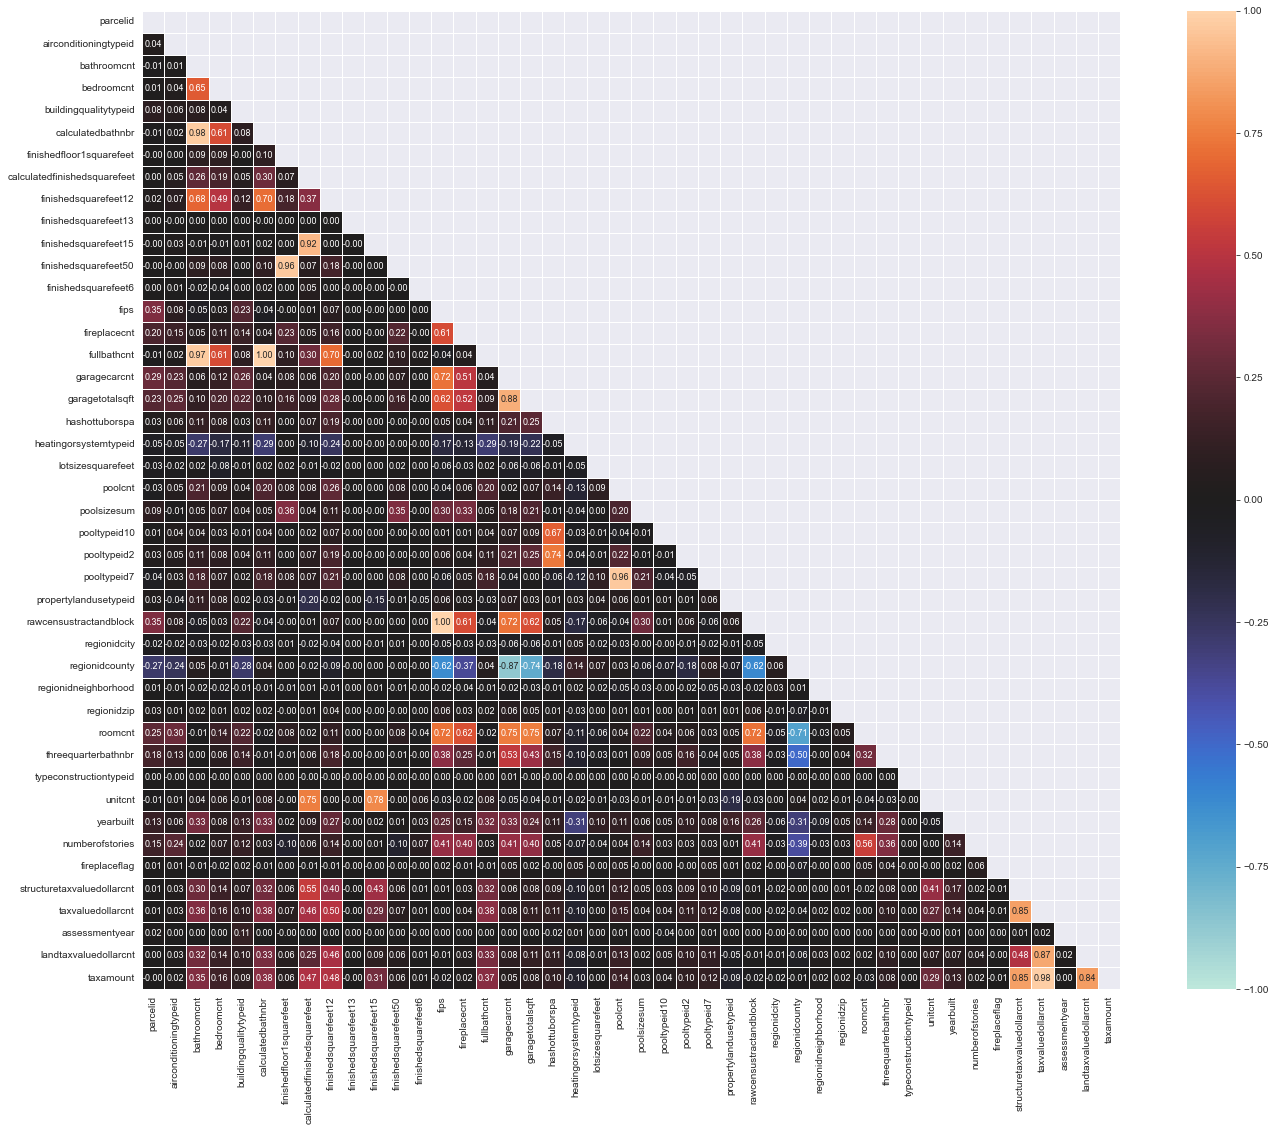

In [486]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = properties.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.close("all")
f, ax = plt.subplots(figsize=(24, 18))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, vmax=1.0, vmin=-1.0, center=0, square=True, annot=True, fmt=".2f", annot_kws={"size": 9},
           linewidths=.5)

We note from the heatmap that some columns seems to be highly correlated: I'll set a threshold and I'll leave on the dataset only one column between each correlated group, and I choose to keep the column with less NaN.
This is a process that can't be automated too much because someone (myself) need to understand the groups of correlated variables (based on columns names), making sure is not spurious correlation (for example `regionidcounty` and `garagecount`)

In [487]:
from texttable import Texttable

t = Texttable()
t.add_rows([["row", "column", "correlation"]])
threshold = 0.9

for r in corr.columns:
    for c in corr.columns:
        if abs(corr.loc[r, c]) >= 0.85  and corr.columns.get_loc(r) > corr.columns.get_loc(
                c):  # check also to take only values under the main diagonal (to avoid repetitions)
            t.add_row([r, c, corr.loc[r, c]])

print(t.draw())

+------------------------+------------------------------+-------------+
|          row           |            column            | correlation |
+========================+==============================+=============+
| calculatedbathnbr      | bathroomcnt                  | 0.975       |
+------------------------+------------------------------+-------------+
| finishedsquarefeet15   | calculatedfinishedsquarefeet | 0.921       |
+------------------------+------------------------------+-------------+
| finishedsquarefeet50   | finishedfloor1squarefeet     | 0.964       |
+------------------------+------------------------------+-------------+
| fullbathcnt            | bathroomcnt                  | 0.975       |
+------------------------+------------------------------+-------------+
| fullbathcnt            | calculatedbathnbr            | 0.999       |
+------------------------+------------------------------+-------------+
| garagetotalsqft        | garagecarcnt                 | 0.885 

So the groups can be:
- calculatedbathnbr, bathroomcnt, fullbathcnt
- finishedsquarefeet15, calculatedfinishedsquarefeet, finishedsquarefeet50, finishedfloor1squarefeet
- pooltypeid7, poolcnt
- garagetotalsqft, garagecarcnt
- rawcensustractandblock, fips
- landtaxvaluedollarcnt, taxvaluedollarcnt, taxamount

For each of them, I'll take the one with more non-NaN value and keep only it

In [488]:
groups = [['calculatedbathnbr', 'bathroomcnt', 'fullbathcnt'],
          ['finishedsquarefeet15', 'calculatedfinishedsquarefeet', 'finishedsquarefeet50', 'finishedfloor1squarefeet'],
          ['pooltypeid7', 'poolcnt'],
          ['rawcensustractandblock', 'fips'],
          ['landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount']]

print(f"#columns before: {properties.shape[1]}")

for g in groups:
    min_nan = properties.shape[0]
    to_keep = ""
    # print(f"GROUP {g}")
    for el in g:
        # print(f"{el}: {properties[el].isna().sum()} nan")
        if properties[el].isna().sum() < min_nan:
            min_nan = properties[el].isna().sum()
            to_keep = el
    g.remove(to_keep)
    # print(f"REMOVE: {g}")

    properties.drop(columns=g, inplace=True)

print(f"#columns after: {properties.shape[1]}")

#rows before: 389108
#rows after: 389108


#### Charts on variable distributions for numerical columns
Let's visualize the distribution of each column, in order to understand how data is distributed and if there are outliers through a boxplot

In [490]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet6',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'typeconstructiontypeid', 'unitcnt', 'yearbuilt', 'numberofstories',
       'fireplaceflag', 'structuretaxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt'],
      dtype='object')

In [491]:
categorical_columns = ['airconditioningtypeid', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'rawcensustractandblock', 'regionidcity', 'regionidcounty',
                       'regionidneighborhood', 'regionidzip', 'typeconstructiontypeid', 'yearbuilt', 'fireplaceflag']
numerical_columns = ['bedroomcnt', 'calculatedbathnbr', 'finishedsquarefeet12', 'finishedsquarefeet13',
                     'finishedsquarefeet15', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
                     'lotsizesquarefeet', 'poolsizesum', 'roomcnt',
                     'threequarterbathnbr', 'unitcnt', 'numberofstories' 'landtaxvaluedollarcnt']

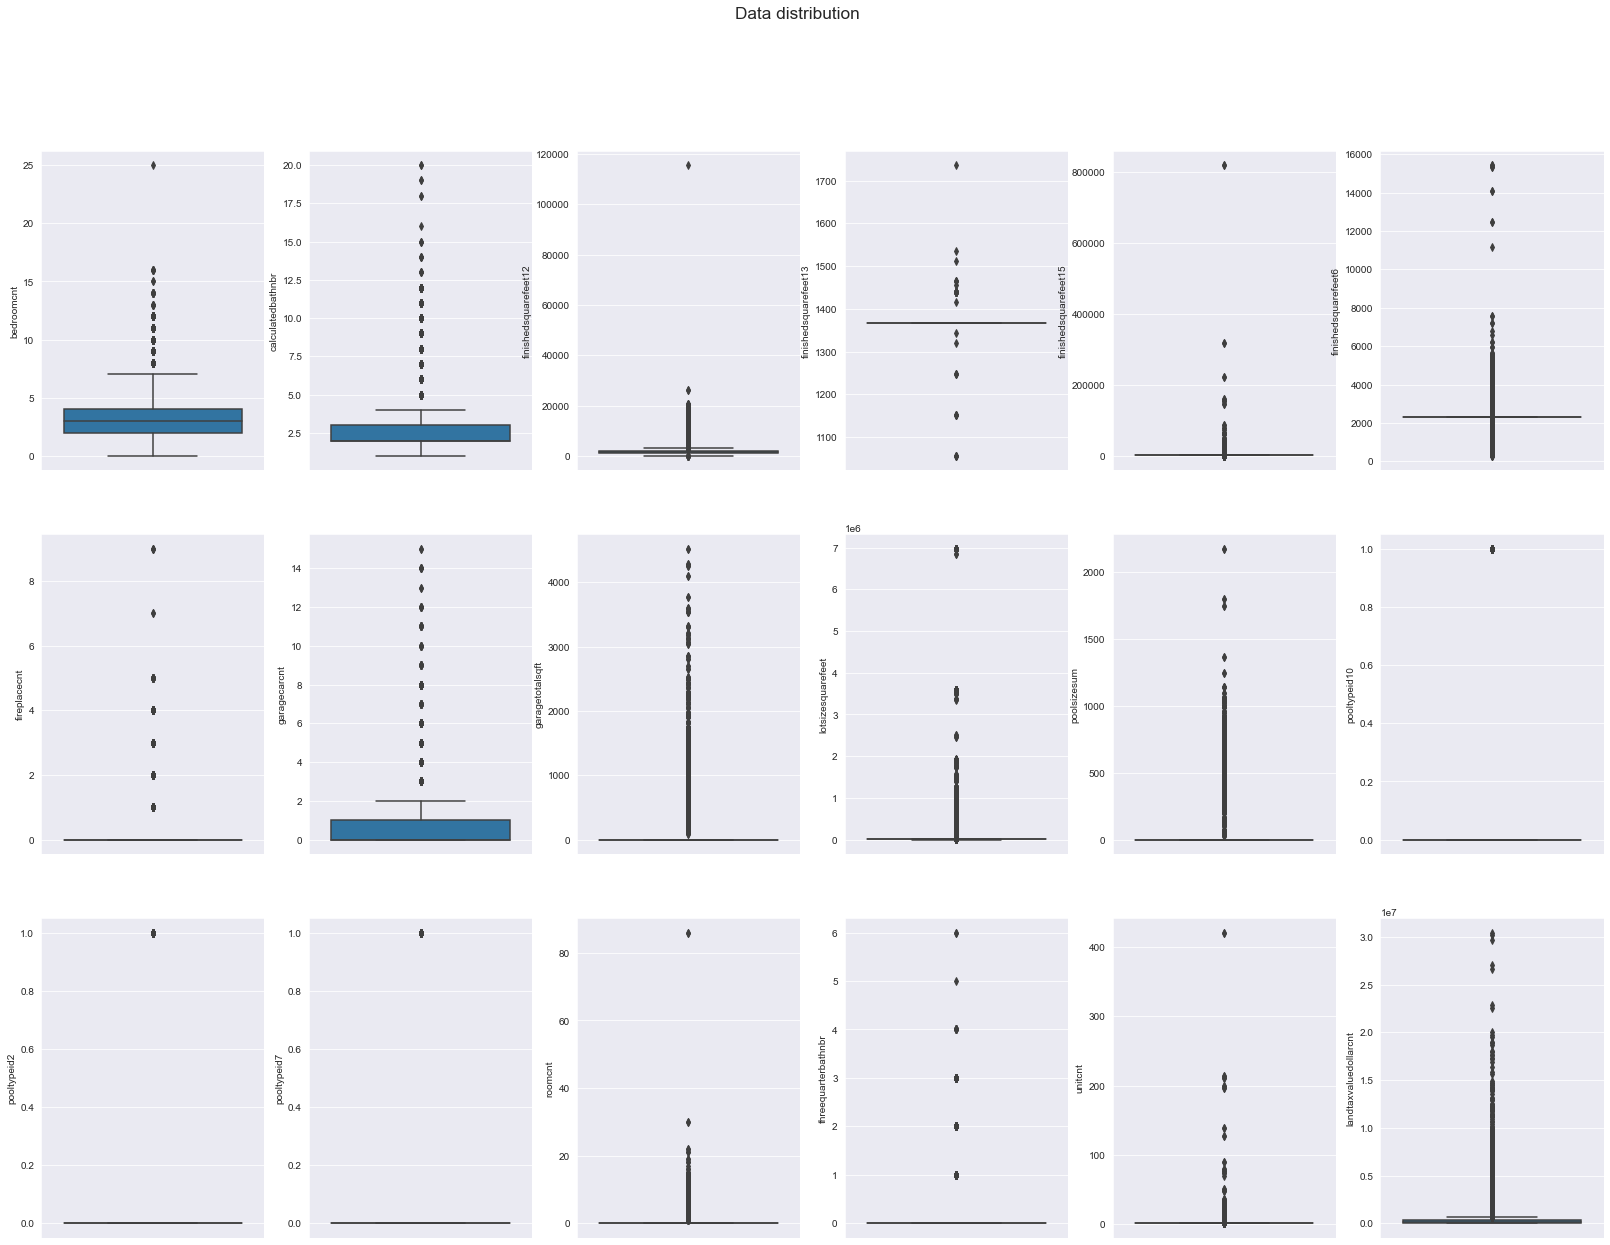

In [496]:
from matplotlib import pyplot as plt
import seaborn as sb

fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(28, 20))
fig.suptitle('Data distribution', size='xx-large')

#sb.boxplot(ax=ax[0, 0], y=properties["calculatedbathnbr"]) # with seaborn

i=0
for col in numerical_columns:
    sb.boxplot(ax=ax[i//6, i%6], y=properties[col])
    i+=1

We can observe that many features has many concentrated values, and this is also because of the filling of NaN that I done before

#### Charts of distribution for categorical columns
For categorical columns, let's visualize the number of levels, in order to have an idea if it's feasible to perform one-hot-encoding

int32
int32
int32
int32
int32


KeyError: 'propertycountylandusecode'

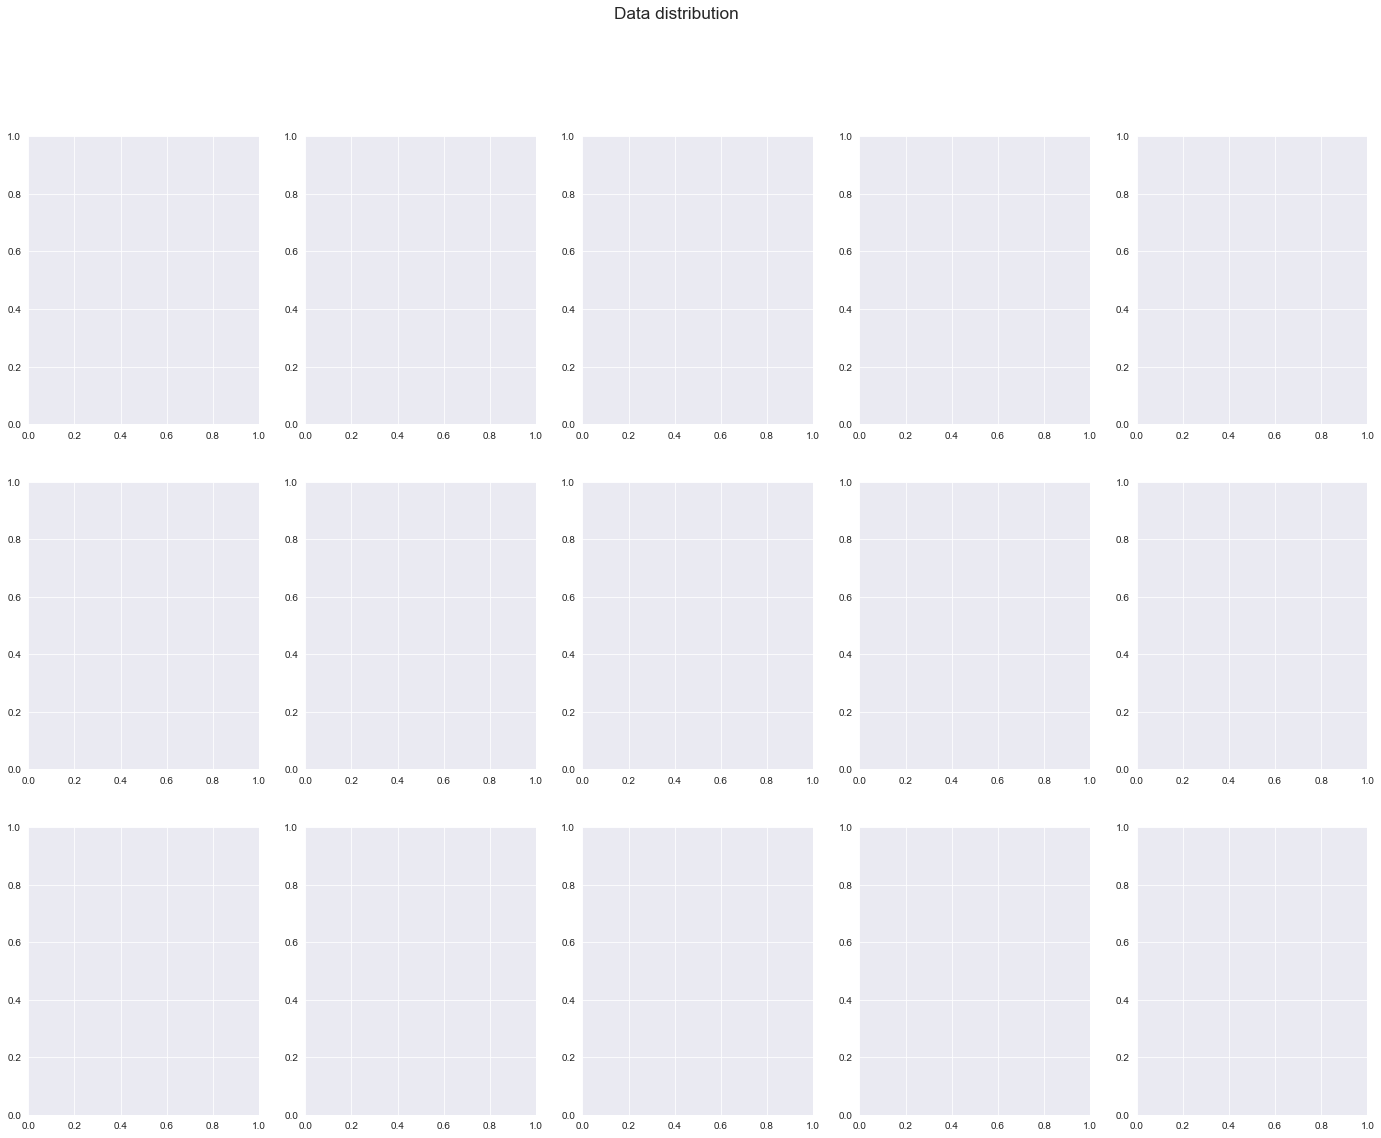

In [343]:
# grafico con sulle x le colonne e sulle y i livelli
import seaborn as sb

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(24, 18))
fig.suptitle('Data distribution', size='xx-large')
i = 0

#ax[0,0].hist(properties.airconditioningtypeid)
#ax[0,1].hist(properties.buildingqualitytypeid)
#ax[0,2].hist(properties.hashottuborspa)
for c in categorical_columns:
    #ax[i//5,i%5].hist(properties[c])
    #i+=1
    print(properties[c].dtype)

### NaN handle

## Explorative analysis of `transactions` dataset

## Joining datasets and exporting data to create models

Joino i dataset e li esporto tipo in .csv al fine di avere i dati pronti per la creazione dei modelli e poi droppo parcelid





Useful resources:
- https://stackoverflow.com/questions/15819050/pandas-dataframe-concat-vs-append


#print(properties.columns[ properties.isna().any()].tolist()) # colonne che hanno almeno un valore null

